In [1]:
# Cell 0 — imports & paths
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt

# Try to infer repo root; adjust manually if needed
# If your notebook is in notebooks/, this should point to repo root
CWD = Path.cwd()
if (CWD / "data").exists() and (CWD / "scripts").exists():
    ROOT = CWD
elif (CWD.parent / "data").exists():
    ROOT = CWD.parent
else:
    # Fallback — EDIT if needed
    ROOT = Path(r"C:\Users\andre\Documents\github\HumanNatureAttunement")

PROCESSED = ROOT / "data" / "processed"
print("ROOT =", ROOT)
print("PROCESSED =", PROCESSED)

# Subjects: auto-discover or provide a fixed list
AUTO_SUBJECTS = [p.name.split("-")[-1] for p in sorted(PROCESSED.glob("sub-*"))]
SUBJECTS = ["02", "03", "05", "06", "07"]  # your current set
print("Found subjects:", AUTO_SUBJECTS)


ROOT = c:\Users\andre\Documents\github\HumanNatureAttunement
PROCESSED = c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed
Found subjects: ['02', '03', '05', '06', '07']


In [3]:
# Cell 1 — cleaner utilities

FS = 256.0  # Hz (your annotated tables rate)

def _bandpass_sos(x, fs, lo=0.05, hi=1.0, order=4):
    ny = 0.5 * fs
    lo = max(1e-6, lo/ny)
    hi = min(0.99,   hi/ny)
    sos = butter(order, [lo, hi], btype="band", output="sos")
    return sosfiltfilt(sos, x)

def clean_respiration(raw_series: pd.Series, fs: float = FS) -> np.ndarray:
    """Interpolate → center → scale → stable bandpass (0.05–1 Hz) → z-score."""
    x = raw_series.astype(float).to_numpy()

    # 1) interpolate NaNs both directions
    xi = pd.Series(x).interpolate("linear", limit_direction="both").to_numpy()

    # 2) center
    xc = xi - np.nanmean(xi)

    # 3) scale before filtering (numeric stability)
    maxabs = np.nanmax(np.abs(xc)) or 1.0
    xs = xc / maxabs

    # 4) bandpass (SOS, numerically stable)
    xf = _bandpass_sos(xs, fs=fs, lo=0.05, hi=1.0, order=4)

    # 5) z-score
    mu, sd = np.mean(xf), np.std(xf) + 1e-12
    xz = (xf - mu) / sd
    return xz


In [4]:
# Cell 2 — IO & per-subject processing

def load_table(subj: str, fs: float = FS):
    tables = PROCESSED / f"sub-{int(subj):02d}" / "tables"
    csv = tables / "merged_annotated_with_audio.csv"
    if not csv.exists():
        raise FileNotFoundError(f"[{subj}] not found: {csv}")
    df = pd.read_csv(csv, low_memory=False)
    if "time_s" not in df.columns:
        df["time_s"] = np.arange(len(df), dtype=float) / fs
    return df, csv

def save_table(df: pd.DataFrame, path: Path, make_backup: bool = True):
    if make_backup:
        bkp = path.with_name(path.stem + "__backup_before_respclean.csv")
        if not bkp.exists():
            df.to_csv(bkp, index=False)
            print("  backup saved →", bkp)
    df.to_csv(path, index=False)
    print("  wrote →", path)

def process_subject_resp(subj: str, overwrite: bool = False, fs: float = FS):
    """Add respiration_clean to merged_annotated_with_audio.csv for one subject."""
    try:
        df, path = load_table(subj, fs=fs)
    except FileNotFoundError as e:
        return dict(subject=subj, status="missing_table", note=str(e))

    if "respiration" not in df.columns:
        return dict(subject=subj, status="no_respiration_col", note="respiration column not found")

    if ("respiration_clean" in df.columns) and (not overwrite):
        return dict(subject=subj, status="exists", note="respiration_clean already present")

    # compute & attach
    rc = clean_respiration(df["respiration"], fs=fs)
    df["respiration_clean"] = rc

    # write back (with one-time backup)
    save_table(df, path, make_backup=True)

    return dict(
        subject=subj,
        status="ok",
        rows=len(df),
        n_nan_clean=int(np.isnan(rc).sum()),
        mean=float(np.mean(rc)),
        std=float(np.std(rc)),
    )


In [5]:
# Cell 3 — batch clean

subjects = SUBJECTS  # or AUTO_SUBJECTS
OVERWRITE = False    # set True to recompute even if column exists

batch_report = []
for s in subjects:
    print(f"\n[{s}] cleaning respiration…")
    rep = process_subject_resp(s, overwrite=OVERWRITE, fs=FS)
    batch_report.append(rep)

batch_df = pd.DataFrame(batch_report)
display(batch_df)



[02] cleaning respiration…
  backup saved → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\merged_annotated_with_audio__backup_before_respclean.csv
  wrote → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\merged_annotated_with_audio.csv

[03] cleaning respiration…
  backup saved → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-03\tables\merged_annotated_with_audio__backup_before_respclean.csv
  wrote → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-03\tables\merged_annotated_with_audio.csv

[05] cleaning respiration…
  backup saved → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-05\tables\merged_annotated_with_audio__backup_before_respclean.csv
  wrote → c:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-05\tables\merged_annotated_with_audio.csv

[06] cleaning respiration…
  backup saved → c:\Users\andre\Documents\

,subject,status,rows,n_nan_clean,mean,std
0,02,ok,503199,0,1.581497e-18,1.0
1,03,ok,549948,0,-1.519413e-17,1.0
2,05,ok,569339,0,6.190147e-18,1.0
3,06,ok,600258,0,6.818278e-18,1.0
4,07,ok,187915,0,-1.527602e-17,1.0


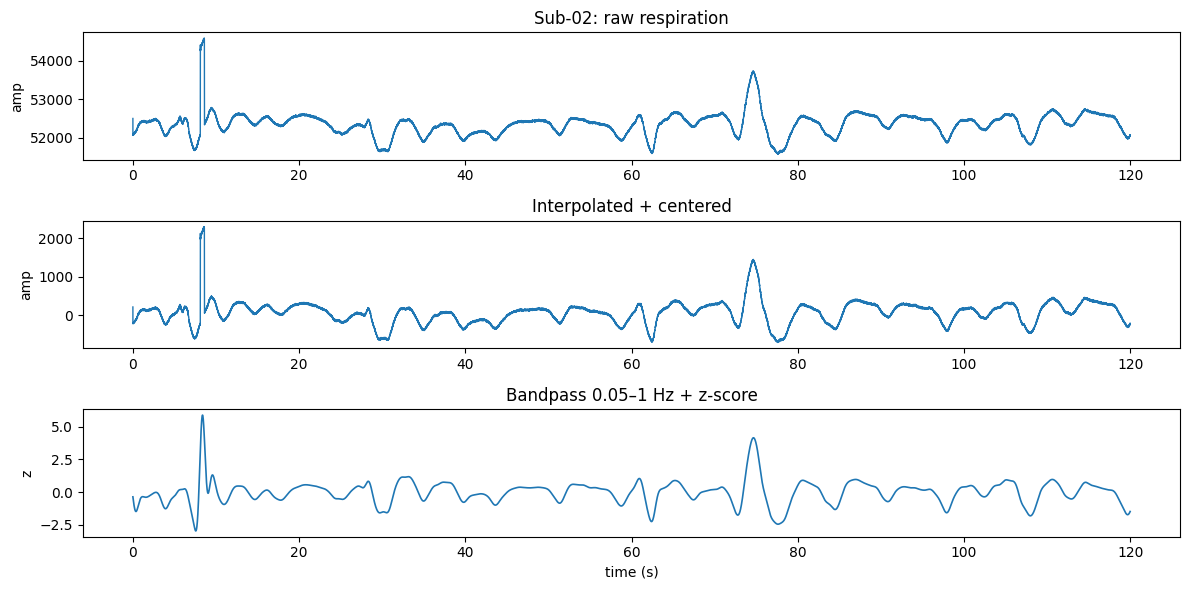

In [6]:
# Cell 4 — sanity plot for a subject (change subj as needed)

subj_plot = "02"
dfp, _ = load_table(subj_plot, fs=FS)
if "respiration_clean" not in dfp.columns:
    dfp["respiration_clean"] = clean_respiration(dfp["respiration"], fs=FS)

t = dfp["time_s"].to_numpy()
mask = (t <= (t[0] + 120.0))

plt.figure(figsize=(12,6))

plt.subplot(3,1,1)
plt.plot(t[mask], dfp.loc[mask, "respiration"], lw=1)
plt.title(f"Sub-{subj_plot}: raw respiration"); plt.ylabel("amp")

plt.subplot(3,1,2)
raw_interp = (pd.Series(dfp["respiration"])
              .interpolate("linear", limit_direction="both"))
centered = raw_interp - raw_interp.mean()
plt.plot(t[mask], centered[mask], lw=1)
plt.title("Interpolated + centered"); plt.ylabel("amp")

plt.subplot(3,1,3)
plt.plot(t[mask], dfp.loc[mask, "respiration_clean"], lw=1.2)
plt.title("Bandpass 0.05–1 Hz + z-score"); plt.xlabel("time (s)"); plt.ylabel("z")

plt.tight_layout(); plt.show()


In [ ]:
# Cell 5 — optional full overwrite
OVERWRITE = True
batch_report_over = []
for s in SUBJECTS:
    print(f"\n[{s}] re-clean respiration (overwrite)…")
    rep = process_subject_resp(s, overwrite=OVERWRITE, fs=FS)
    batch_report_over.append(rep)
pd.DataFrame(batch_report_over)
